# La2CuO4 version Fit modes 

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from La2CuO4_alris_functions2 import shift_atoms, transform_list_hkl_p63_p65, get_structure_factors , atom_position_list
from itertools import chain
from matplotlib.markers import MarkerStyle
from tqdm import tqdm
from time import time

%config InlineBackend.figure_format = 'svg' # make figures appears in .svg style

num_threads = 2  

# Configure TensorFlow to use multiple threads
tf.config.threading.set_intra_op_parallelism_threads(num_threads)
tf.config.threading.set_inter_op_parallelism_threads(num_threads)

print(f"Using {num_threads} threads for intra-op and inter-op parallelism.")

num_of_params = 20

Using 2 threads for intra-op and inter-op parallelism.


Define the function containing the fitting parameters

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- `fun_tf()` correspond to the **structure factor calculation function** (one has to convert it to a **TF-compatible** function)
- <span style="color:red">If conversion to TF-compatible function is not possible, then this approach will probably not work (or becomes much more tedious at least)</span>

In [56]:
#convert the simulated data to log10 scale (if needed)

def log10(x):
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

In [57]:
def fun_tf(x, pars):
    """
    Fast computation of structure factors with parameter-dependent structure.
        # Get modified structure
    modified_struct = shift_atoms_p65(*pars)
    neg_h = tf.stack([-x[:, 0], x[:, 1], x[:, 2]], axis=1)
    x_combined = tf.concat([x, neg_h], axis=0)  # Shape [2N, 3]

    x_combined = transform_list_hkl_p63_p65(x_combined)

    # Get structure factors
    sf_combined = get_structure_factors(x_combined, modified_struct)
    # Compute intensity
    # Split and compute intensity
    sf_hkl = sf_combined[:tf.shape(x)[0]]
    sf_neg_k = sf_combined[tf.shape(x)[0]:]
    
    intensity = (tf.abs(sf_hkl) + tf.abs(sf_neg_k)) ** 2
    return intensity / tf.reduce_max(intensity)
    """
    # Get modified structure
    atom_shift_list = shift_atoms(*pars)
    print(f"Shape of atom_shift_list: {len(atom_shift_list)}")



    # Flatten atom_shift_list if it contains nested lists
    flat_atom_shift_list = list(chain.from_iterable(
        x if isinstance(x, list) else [x] for x in atom_shift_list
    ))
    modified_struct = atom_position_list(*flat_atom_shift_list)

    #neg_h = tf.stack([-x[:, 0], x[:, 1], x[:, 2]], axis=1)
    x_combined = x
    #x_combined = tf.concat([x, neg_h], axis=0)  # Shape [2N, 3]

    x_combined = transform_list_hkl_p63_p65(x_combined)

    # Get structure factors
    sf_combined = get_structure_factors(x_combined, modified_struct)
    # Compute intensity
    # Split and compute intensity
    sf_hkl = sf_combined[:tf.shape(x)[0]]
    
    print(f"Shape of sf_combined: {sf_combined.shape}, Shape of x_combined: {x_combined.shape}")
    
    intensity = (tf.abs(sf_hkl)) ** 2
    # w = tf.constant(0.00159, dtype=tf.float32)  # Debye-Waller factor is 0.00159
    w = tf.constant(0, dtype=tf.float32)  # Debye-Waller factor is 0.00159
    qnorms = tf.norm(tf.cast(x_combined[:tf.shape(x)[0]], tf.float32), axis=1)
    # qnorms = tf.reshape(qnorms, (-1, 1))  # Reshape to match the shape of intensity
    intensity = intensity * tf.exp(-w * qnorms ** 2)  # Apply Debye-Waller factor
    #intensity = log10(intensity + 1)  # Convert to log10 scale
    intensity_summed = tf.reduce_sum(intensity)  # Sum intensity for normalization
    intensity_unscaled = intensity  # Store unscaled intensity
    intensity_scaled = intensity / intensity_summed
    return intensity_scaled , intensity_summed , intensity_unscaled


In [58]:
experimental_data = pd.read_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/La2CuO4/raw_data/peaks1.csv')
"""
# reduce data to l in [0.5, 1.5, 2.5, 3.5, 4.5 ]
experimental_data = experimental_data[
    (experimental_data["l"] == 0.5) |
    (experimental_data["l"] == 1.5) |
    (experimental_data["l"] == 2.5) |
    (experimental_data["l"] == 3.5) |
    (experimental_data["l"] == 4.5)
]
"""
hkl_list = experimental_data[["h", "k", "l"]].values.tolist()
hkl_list = tf.convert_to_tensor(hkl_list, dtype=tf.float32)
print(experimental_data.shape)

(67, 4)


Sample the "training data" (features and labels)

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The features are the (h,k,l) coordinates (e.g. a vector of size `n_features` x 3, i.e. `n_dim = 3`)
- Maybe one has to normalize the features (i.e. not using integers but floats between -1 (0) and 1)? Before passing them to the structure calculation function, they should be again rescaled to integers
- The labels would be the experimental intensities (again, maybe have to be normalized to the range between 0 and 1)

Max label err: 10.08005
min label err: 3.8955534
Features shape: (67, 3)
Labels shape: (67, 1)
error shape: (67, 1)
Max label: 0.033380006
min label : 0.006516382


(array([1., 0., 0., 0., 1., 1., 2., 1., 0., 1., 2., 1., 1., 1., 3., 4., 4.,
        2., 3., 2., 3., 2., 4., 2., 0., 3., 4., 3., 2., 2., 0., 1., 1., 1.,
        0., 4., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.]),
 array([ 3.89555335,  4.01924324,  4.14293337,  4.26662302,  4.39031315,
         4.51400328,  4.63769293,  4.76138306,  4.88507271,  5.00876284,
         5.13245296,  5.25614262,  5.37983274,  5.5035224 ,  5.62721252,
         5.75090265,  5.8745923 ,  5.99828243,  6.12197208,  6.24566221,
         6.36935234,  6.49304199,  6.61673212,  6.74042225,  6.8641119 ,
         6.98780203,  7.11149168,  7.23518181,  7.35887194,  7.48256159,
         7.60625172,  7.72994137,  7.8536315 ,  7.97732162,  8.10101128,
         8.22470093,  8.34839153,  8.47208118,  8.59577084,  8.71946144,
         8.84315109,  8.96684074,  9.09053135,  9.214221  ,  9.33791065,
         9.4616003 ,  9.58529091,  9.70898056,  9.83267021,  9.95636082,
        10.08005047]),
 <BarContainer object

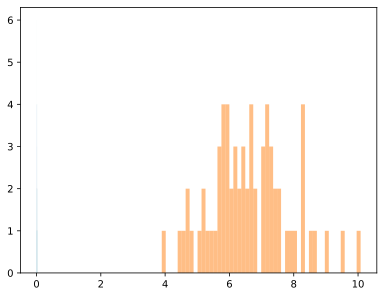

In [59]:
n_features = experimental_data.shape[0]
n_dim = 3

features = hkl_list
labels = experimental_data["intensity_exp"].tolist()
labels = labels / np.sum(labels)  # Normalize labels

labels_err = []
for label in labels:
    # labels_err.append(np.sqrt(0.8/label) - 1.5)
    labels_err.append(np.sqrt(0.8/label) - 1)


labels_err = tf.convert_to_tensor(labels_err, dtype=tf.float32)
labels = tf.convert_to_tensor(labels, dtype=tf.float32)

labels = tf.expand_dims(labels, axis=-1)  # Ensure labels are 2D
labels_err = tf.expand_dims(labels_err, axis=-1)  # Ensure labels_err are 2D

print("Max label err:", np.max(labels_err))
print("min label err:", np.min(labels_err))
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)
print('error shape:', labels_err.shape)
print("Max label:", np.max(labels))
print("min label :", np.min(labels))
plt.hist(labels.numpy(), bins=50, alpha=0.5, label='Labels')
plt.hist(labels_err.numpy(), bins=50, alpha=0.5, label='Labels Error')


Define a simple model

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The six parameters (a,b,c,d,e,f) correspond to the fractional atomic shifts in the modes w.r.t. unit cell lengths
- Instead of `sigmoid`, `tanh` should be applied to the parameters before passing them to the structure factor calculation function (ensures smoother gradient landscape)
- The `tanh` function can furthermore be limited to a specific range (e.g. if atomic distortions should not exceed +- 0.1)

In [63]:
class FunAsLayer(tf.keras.layers.Layer):
    def __init__(self, max_mode_amps,**kwargs):
        super().__init__(**kwargs)
        self.max_mode_amps = max_mode_amps

    def build(self, input_shape):
        self.param = self.add_weight(name='param', shape=(num_of_params,), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        # Apply tanh to ensure parameters stay within the [-1, 1] range then multiply by max_mode_amps so each parameter is scaled corresponding to the element in max_mode_amps
        pretransform = tf.tanh(self.param)
        transformed_params = pretransform * self.max_mode_amps  # Scale parameters

        output, intensity_summed  , intensity_unscaled = fun_tf(inputs, tf.unstack(transformed_params))
        return tf.reshape(output , [-1]) # Ensure output is 1D




Create optimizer and define loss function

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The learning rate must be determined by experimentation (same holds for the batch size and the number of epochs below)
- As a loss function, one can try either MSE or R-score (MSE seems to be the more "natural choice" in this case)

In [61]:
"""
# R-Score based on intensity
class RFactorLoss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        return tf.reduce_sum(tf.abs(y_true - y_pred)) / tf.reduce_sum(y_true)
"""
    
# mean squared error
class PerSampleMSE(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__(reduction=tf.keras.losses.Reduction.NONE)

    def call(self, y_true, y_pred):
        squared_error = tf.square(y_true - y_pred)
        per_sample_mse = tf.reduce_mean(squared_error, axis=-1)
        return per_sample_mse  # shape (batch_size,)

class MSE_weighted(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        # Assume y_true = [labels, errors]
        print('ytrue shape:', y_true.shape)
        print('y true' , y_true)
        labels = y_true[:, 0]
        weights = y_true[:, 1]

        mse = tf.square(labels - y_pred)
        return tf.reduce_sum(mse * weights) / tf.reduce_sum(weights)


# Define the custom metric function
def r_factor_metric(y_true, y_pred):
    labels = y_true
    return tf.reduce_sum(tf.abs(labels - y_pred)) / tf.reduce_sum(labels)


Train the model for n iterations (to try different initial weights)

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The number of iterations defines the "starting position" $w_0$ of the gradient descent algorithm
- Because there are probably many local minima, changing $w_0$ allows the algorithm to find different minima and increases the chances of finding the global minima

labels shape: (67, 1)
labels_err shape: (67, 1)
Learning rate: 0.003
max_mode_amps shape: (20,)
Shape of atom_shift_list: 156
Shape of sf_combined: (None,), Shape of x_combined: (None, 3)
Epoch 1/100
Shape of atom_shift_list: 156
Shape of sf_combined: (67,), Shape of x_combined: (67, 3)
Shape of atom_shift_list: 156
Shape of sf_combined: (67,), Shape of x_combined: (67, 3)
1/1 [==============================] - 7s 7s/step - loss: 0.0042 - r_factor_metric: 1.2831
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0040 - r_factor_metric: 1.2717
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0038 - r_factor_metric: 1.2603
Epoch 4/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0037 - r_factor_metric: 1.2495
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0036 - r_factor_metric: 1.2399
Epoch 6/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0035 - r_factor_metric: 1.2329
Epoch 7/100
1

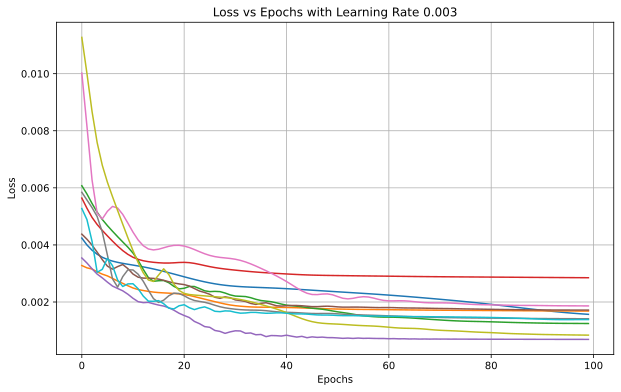

In [65]:
#squeeze labels and labels_err to ensure they are 1D tensors
#labels = tf.squeeze(labels)
#labels_err = tf.squeeze(labels_err)

print("labels shape:", labels.shape)
print("labels_err shape:", labels_err.shape)


lr = [3e-3]
best_pars_overall = None
best_rf_overall = np.inf
best_loss_overall = []
for learning_rate in lr:
    time_start = time()
    print(f"Learning rate: {learning_rate}")
    optim = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    max_mode_amps = tf.constant([5.66,5.66,5.66,5.66,5.66,5.66,5.66,5.66,5.66,5.66,5.66,8.0,8.0,8.0,8.0,8.0,8.0,5.66,5.66,5.66], dtype=tf.float32) 
    print("max_mode_amps shape:", max_mode_amps.shape)

    n_epochs = 100
    histories = []
    n_iter = 10

    min_loss = np.inf
    best_pars = None

    # List to store the loss values for each epoch
    all_losses = []
    r_factor_list = []
    intensity_summed_list = []


    for i in range(n_iter):
        # Create the model
        inputs = tf.keras.Input(shape=(n_dim,))
        outputs = FunAsLayer(max_mode_amps)(inputs)
        model = tf.keras.Model(inputs, outputs)

        # Compile the model with the custom loss function and metric
        model.compile(
            optimizer=optim,
            loss= 'mse', # MSE_weighted() if using errors
            metrics=[r_factor_metric]

        )
        
        history = model.fit(
        x=features,
        y=labels,  # replace with combined_labels if using errors
        batch_size = features.shape[0], # Use a smaller batch size features.shape[0]
        epochs=n_epochs,
        verbose='auto',
        shuffle=True, # not sure whether this matters
        # callbacks=[cb]
        sample_weight=labels_err  # Use sample weights if you have errors
        )

        histories.append(history)
        all_losses.append(history.history['loss'])
 
        # Check final loss
        final_loss = history.history['loss'][-1]
        print(model.layers[-1].get_weights()[0].shape)
        curren_model_pars = max_mode_amps * tf.tanh(model.layers[-1].get_weights()[0])
        print(f"Final loss: {final_loss:.3e}")
        '''
        print(f"Best parameters for iteration {i+1}:")
        for j, par in enumerate(curren_model_pars):
            print(f"Parameter {j+1}: {par.numpy():.4f}")
        '''

        if final_loss < min_loss:
            # Update best model parameters
            best_model_pars = max_mode_amps * tf.tanh(model.layers[-1].get_weights()[0])
            min_loss = final_loss
            intensity_scaled , intensity_summed , intensity_unscaled= fun_tf(features, best_model_pars)
            rf = r_factor_metric(labels, intensity_scaled)
            #print(f"Iteration {i+1} - New best loss: {min_loss:.3e} (R-factor: {rf:.3e})")

    if min_loss < best_rf_overall:
        best_rf_overall = min_loss
        best_pars_overall = best_model_pars
        best_loss_overall = all_losses
        best_intensity_summed = intensity_summed
    print(f"time elapsed: {time() - time_start:.2f} seconds")
    print(f"With {n_epochs*n_iter /(time() - time_start)} iterations per second")
    # Plotting the loss values
    plt.figure(figsize=(10, 6))

    # Plot the loss values for each iteration
    for i, loss_values in enumerate(all_losses):
        plt.plot(loss_values, label=f'Iteration {i+1}')

    plt.title(f'Loss vs Epochs with Learning Rate {learning_rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # plt.legend()
    plt.grid(True)
    plt.show()


min loss: 0.0006889558280818164


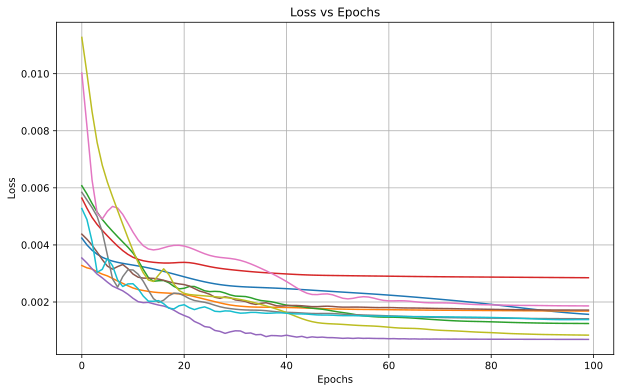

In [66]:
all_losses = best_loss_overall
best_model_pars = best_pars_overall
min_loss = best_rf_overall

print(f"min loss: {min_loss}")


# Plotting the loss values
plt.figure(figsize=(10, 6))

# Plot the loss values for each iteration
for i, loss_values in enumerate(all_losses):
    plt.plot(loss_values, label=f'Iteration {i+1}')

plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.legend()
plt.grid(True)
plt.show()

In [67]:
mode_names = pd.read_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/La2CuO4/raw_data/La2CuO4_displacivemode_names.txt' , delim_whitespace=True, header=None)

mode_names = mode_names.values.tolist()
mode_names = pd.DataFrame(mode_names)

# Print the best model parameters
print("min loss:", min_loss)
print("Best model parameters:") 
for i, par in enumerate(best_model_pars):
    print(f"{mode_names.iloc[i , 0]} : {par.numpy():.8f}")
    
# Print the model summary
print("Number of iterations:", n_iter)
print("Number of features:", n_features)
#modes = get_mode_amplitudes_p63(*best_model_pars)
#print("Modes:")
##for key, val in modes.items():
    #print(f"{key}: {val*1000:.4f}")

min loss: 0.0006889558280818164
Best model parameters:
Cmca[1,0,0]Y1+(a)[La1:f:dsp] : -0.11537293
Cmca[1,0,0]Y1+(a)[La1:f:dsp] : -1.96259832
Cmca[1,0,0]Y3+(a)[La1:f:dsp] : 2.69284725
Cmca[1,0,0]Y3+(a)[La1:f:dsp] : -0.04736518
Cmca[1,0,0]Y1+(a)[O1:f:dsp] : -0.67110425
Cmca[1,0,0]Y1+(a)[O1:f:dsp] : 2.24539399
Cmca[1,0,0]Y3+(a)[O1:f:dsp] : 1.34315622
Cmca[1,0,0]Y3+(a)[O1:f:dsp] : 0.30996472
Cmca[1,0,0]Y1+(a)[O2:e:dsp] : -3.02565551
Cmca[1,0,0]Y3+(a)[O2:e:dsp] : 1.39338470
Cmca[1,0,0]Y3+(a)[O2:e:dsp] : 1.04706049
Cmca[1,0,0]Y1+(a)[O3:g:dsp] : 1.22655296
Cmca[1,0,0]Y1+(a)[O3:g:dsp] : -0.67709523
Cmca[1,0,0]Y1+(a)[O3:g:dsp] : -0.20436326
Cmca[1,0,0]Y3+(a)[O3:g:dsp] : -0.13907675
Cmca[1,0,0]Y3+(a)[O3:g:dsp] : 1.02258027
Cmca[1,0,0]Y3+(a)[O3:g:dsp] : 2.62826777
Cmca[1,0,0]Y1+(a)[O4:e:dsp] : -0.27925611
Cmca[1,0,0]Y3+(a)[O4:e:dsp] : -0.28689283
Cmca[1,0,0]Y3+(a)[O4:e:dsp] : 2.73814869
Number of iterations: 10
Number of features: 67


C:\Users\User\AppData\Local\Temp\ipykernel_15000\3457527789.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mode_names = pd.read_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/La2CuO4/raw_data/La2CuO4_displacivemode_names.txt' , delim_whitespace=True, header=None)


In [95]:
def plot_plane_sim_vs_exp(ax, df, k, min_loss , r_factor , norm_plane=False):
    exp_data_0 = df.loc[df['k'] == k].copy()
    if norm_plane:
        exp_data_0['intensity_sim'] = exp_data_0['intensity_sim'] / np.sum(exp_data_0['intensity_sim'])
        exp_data_0['intensity_exp'] = exp_data_0['intensity_exp'] / np.sum(exp_data_0['intensity_exp'])
    
    ax.scatter(exp_data_0['h'], exp_data_0['l'], 
               s=exp_data_0['intensity_sim'] * 0.1, color='red', edgecolor="black",
               label='Sim', marker=MarkerStyle("o", fillstyle="right"))
    ax.scatter(exp_data_0['h'], exp_data_0['l'], 
               s=exp_data_0['intensity_exp'] * 0.1 , color='blue', edgecolor="black",
               label='Exp', marker=MarkerStyle("o", fillstyle="left"))
    
    ax.set_xlabel(f"h in (h, {k}, l) [r.l.u.]")
    ax.set_ylabel(f"l in (h, {k}, l) [r.l.u.]")
    ax.set_title(f"k = {k} , min loss = {min_loss:.4f}, r-factor (normalised)= {r_factor:.4f}")
    ax.legend()


def plot_plane_sim_vs_exp1(ax, df, l,  min_loss , r_factor , norm_plane=False):
    exp_data_0 = df.loc[df['l'] == l].copy()
    if norm_plane:
        exp_data_0['intensity_sim'] = exp_data_0['intensity_sim'] / np.sum(exp_data_0['intensity_sim'])
        exp_data_0['intensity_exp'] = exp_data_0['intensity_exp'] / np.sum(exp_data_0['intensity_exp'])
    
    ax.scatter(exp_data_0['h'], exp_data_0['k'], 
               s=exp_data_0['intensity_sim'] * 0.1, color='red', edgecolor="black",
               label='Sim', marker=MarkerStyle("o", fillstyle="right"))
    ax.scatter(exp_data_0['h'], exp_data_0['k'], 
               s=exp_data_0['intensity_exp'] * 0.1, color='blue', edgecolor="black",
               label='Exp', marker=MarkerStyle("o", fillstyle="left"))
    
    ax.set_xlabel(f"h in (h, k, {l}) [r.l.u.]")
    ax.set_ylabel(f"k in (h, k, {l}) [r.l.u.]")
    ax.set_title(f"l = {l} , min loss = {min_loss:.4f}, r-factor (normalised)= {r_factor:.4f}")
    ax.legend()

In [69]:
def alris_r_factor(data):
    exp_intensity = data['intensity_exp'] / np.sum(data['intensity_exp'])
    simulated_intensity = data['intensity_sim'] / np.sum(data['intensity_sim'])
    alris_r_factor_normalised = np.sum(np.abs(exp_intensity - simulated_intensity)) / np.sum(np.abs(exp_intensity))

    alris_r_factor_not_normalised = np.sum(np.abs(data['intensity_exp'] - data['intensity_sim'])) / np.sum(np.abs(data['intensity_exp']))
    return alris_r_factor_normalised , alris_r_factor_not_normalised

In [70]:
exp_data = pd.read_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/La2CuO4/raw_data/peaks1.csv')
intensity, intensity_summed , intensity_unscaled = fun_tf(features, best_model_pars)
exp_data['intensity_sim'] = intensity_unscaled.numpy()  # Convert to numpy array for further processing
exp_data['intensity_sim_normalised'] = intensity.numpy()
exp_data['ratio'] = (exp_data['intensity_exp'] / np.sum(exp_data['intensity_exp'])) / (exp_data['intensity_sim'] / np.sum(exp_data['intensity_sim']))
alris_r_factor_value_normalised , alris_r_factor_value_not_normalised  = alris_r_factor(exp_data)
print(f"alris r-factor: {alris_r_factor_value_normalised:.4f}")
print(f"alris r-factor not normalised: {alris_r_factor_value_not_normalised:.4f}")


Shape of atom_shift_list: 156
Shape of sf_combined: (67,), Shape of x_combined: (67, 3)
alris r-factor: 0.5491
alris r-factor not normalised: 1.3231


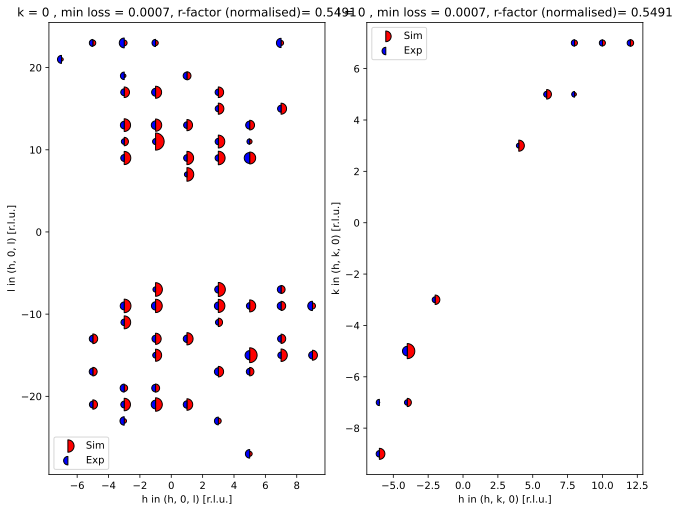

In [96]:
# Prepare subplot grid
fig, axs = plt.subplots(1, 2, figsize=(9, 7), constrained_layout=True)
plt.style.use('default')
plot_plane_sim_vs_exp(axs[0], exp_data, 0, min_loss ,alris_r_factor_value_normalised, norm_plane=False)
plot_plane_sim_vs_exp1(axs[1], exp_data, 0,min_loss ,alris_r_factor_value_normalised, norm_plane=False)

ruggero r-factor: 0.0005
ruggero r-factor not normalised: 0.0005


C:\Users\User\AppData\Local\Temp\ipykernel_15000\203264111.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ruggero = pd.read_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/La2CuO4/raw_data/completely_raw_data.txt' , header=None, delim_whitespace=True)


[Text(0.5, 0, 'ratio'), Text(0, 0.5, 'freq')]

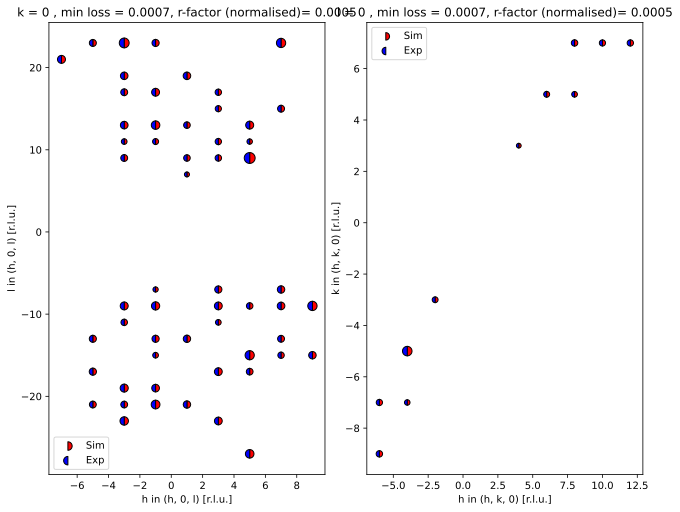

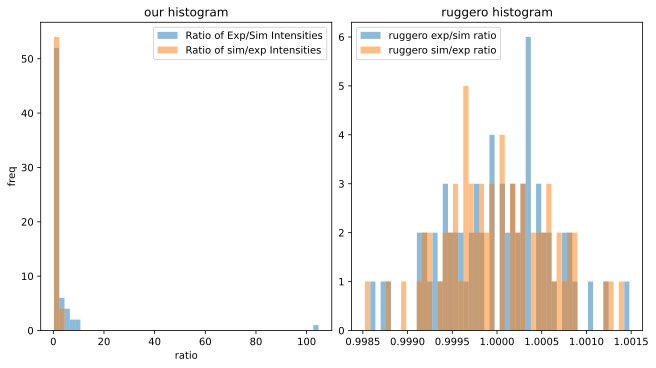

In [97]:
ruggero = pd.read_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/La2CuO4/raw_data/completely_raw_data.txt' , header=None, delim_whitespace=True)
ruggero = ruggero.values.tolist()
ruggero = np.array(ruggero)
ruggero_pd_dataframe = pd.DataFrame({
    'h': ruggero[:,0],
    'k': ruggero[:,1],
    'l': ruggero[:,2],
    'intensity_exp': ruggero[:,3],
    'intensity_sim': ruggero[:,4] * ruggero[:,5],  # Scale the simulated intensity
    'ratio': ruggero[:,5],
})

ruggero_scaled_sim = ruggero[:,4] * ruggero[:,5]
ruggero_ratio = (ruggero[:, 3] / np.sum(ruggero[:,3])) / (ruggero_scaled_sim / np.sum(ruggero_scaled_sim)) # Extract the 5th column
ruggero_rfactor_normalised , ruggero_rfactor_not_normalised = alris_r_factor(ruggero_pd_dataframe)
print(f"ruggero r-factor: {ruggero_rfactor_normalised:.4f}")
print(f"ruggero r-factor not normalised: {ruggero_rfactor_not_normalised:.4f}")

# Prepare subplot grid
fig1, axs = plt.subplots(1, 2, figsize=(9, 7), constrained_layout=True)
plt.style.use('default')
plot_plane_sim_vs_exp(axs[0], ruggero_pd_dataframe , 0, min_loss ,ruggero_rfactor_normalised, norm_plane=False)
plot_plane_sim_vs_exp1(axs[1], ruggero_pd_dataframe , 0,min_loss ,ruggero_rfactor_normalised, norm_plane=False)
exp_data_ratio = exp_data['ratio']

#make subplots for the histograms
fig , (ax1 , ax2) = plt.subplots(1 , 2 , figsize=(9, 5), constrained_layout=True)
ax1.hist(exp_data_ratio, bins=50, alpha=0.5, label='Ratio of Exp/Sim Intensities')
ax1.hist(1/exp_data_ratio, bins=50, range = (np.min(exp_data_ratio) , np.max(exp_data_ratio)),alpha=0.5, label='Ratio of sim/exp Intensities')
ax1.legend()
ax1.set_title('our histogram')
ax1.set(xlabel='ratio', ylabel='freq')
ax2.hist(ruggero_ratio, bins=50, alpha=0.5, label='ruggero exp/sim ratio')
ax2.hist(1/ruggero_ratio, bins=50, alpha=0.5, label='ruggero sim/exp ratio')
ax2.set_title('ruggero histogram')
ax2.legend()
ax1.set(xlabel='ratio', ylabel='freq')


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


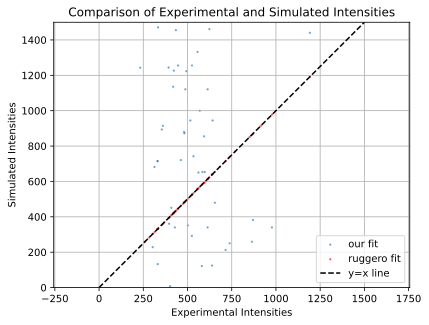

In [94]:
x = np.linspace(0 ,1500, 10000)
y = x
plt.scatter(exp_data['intensity_exp'], exp_data['intensity_sim'], s=2, alpha=0.5 , label='our fit')
plt.scatter(ruggero[:,3] , ruggero_scaled_sim, s=2, alpha=0.5, color='red', label='ruggero fit')
plt.plot(x , y, color='black', linestyle='--', label='y=x line')
plt.legend()
plt.grid(True)
plt.title('Comparison of Experimental and Simulated Intensities')
plt.xlabel('Experimental Intensities')
plt.ylabel('Simulated Intensities')
plt.axis('equal')
plt.xlim(0, 1500)
plt.ylim(0, 1500)
plt.show()

In [43]:
#save the experiment data with simulated intensities
exp_data.to_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/La2CuO4/fitted_data/La2CuO4_peaks_with_simulated_intensities.txt', index=False , sep='\t')

#save all the parameters and the modes
with open('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/La2CuO4/fitted_data/La2CuO4_parameters_and_modes.txt', 'w') as f:
    f.write(f"final loss: {min_loss:.8f}\n")
    f.write(f'r-factor normalised: {alris_r_factor_value_normalised:.8f}\n')
    f.write(f'r-factor not normalised: {alris_r_factor_value_not_normalised:.8f}\n')
    f.write(f"learning_rate: {lr[0]:.8f}\n")
    f.write(f"n_epochs: {n_epochs}\n")
    f.write(f"Best model parameters:\n")
    for i, par in enumerate(best_model_pars):
        f.write(f"{mode_names.iloc[i, 0]} : {par.numpy():.8f} \n")

abs_params = tf.abs(best_model_pars)
best_model_pars_compare = best_model_pars.numpy()
best_model_pars_compare = best_model_pars_compare / np.max(best_model_pars_compare)

#save all the parameters and the modes
with open('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/La2CuO4/fitted_data/La2CuO4_parameters_and_modes_normalised.txt', 'w') as f:
    f.write(f"final loss: {min_loss:.8f}\n")
    f.write(f"learning_rate: {lr[0]:.8f}\n")
    f.write(f"n_epochs: {n_epochs}\n")
    f.write(f"Best model parameters:\n")
    for i, par in enumerate(best_model_pars_compare):
        f.write(f"{mode_names.iloc[i, 0]} : {par:.8f} \n")


NameError: name 'min_loss' is not defined

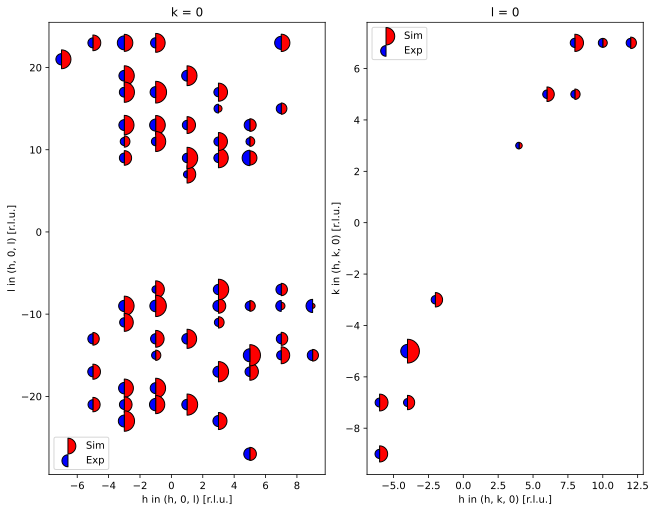

C:\Users\User\AppData\Local\Temp\ipykernel_15000\3890758059.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ruggero = pd.read_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/La2CuO4/raw_data/completely_raw_data.txt' , header=None, delim_whitespace=True)


ruggero r-factor: 0.2465
ruggero r-factor not normalised: 0.7921
alris normalised r-factor for best data: 0.3806
alris not normalised r-factor for best data: 1.6268


[Text(0.5, 0, 'ratio'), Text(0, 0.5, 'freq')]

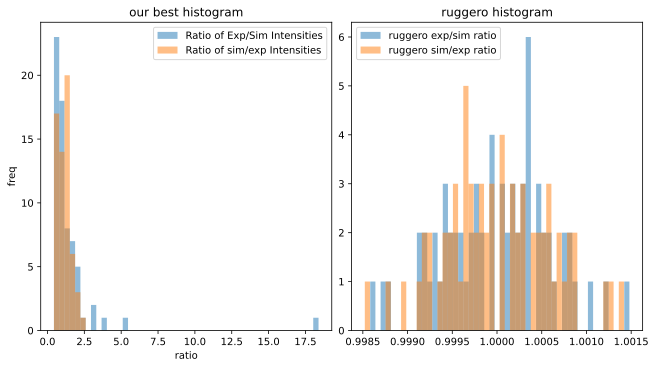

In [41]:
best_data = pd.read_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/La2CuO4/fitted_data/La2CuO4_peaks_with_simulated_intensities.txt' , sep='\t')

best_data_plot = pd.DataFrame({
    'h': best_data['h'],
    'k': best_data['k'],
    'l': best_data['l'],
    'intensity_sim': best_data['intensity_sim'],
    'intensity_exp': best_data['intensity_exp'],
    'ratio': best_data['ratio'],
})
best_data_ratio = best_data_plot['ratio']
# Prepare subplot grid
fig, axs = plt.subplots(1, 2, figsize=(9, 7), constrained_layout=True)
plt.style.use('default')
plot_plane_sim_vs_exp(axs[0], best_data, 0, norm_plane=False)
plot_plane_sim_vs_exp1(axs[1], best_data, 0, norm_plane=False)
plt.show()

ruggero = pd.read_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/La2CuO4/raw_data/completely_raw_data.txt' , header=None, delim_whitespace=True)
ruggero = ruggero.values.tolist()
ruggero = np.array(ruggero)
ruggero_pd_dataframe = pd.DataFrame({
    'h': ruggero[:,0],
    'k': ruggero[:,1],
    'l': ruggero[:,2],
    'intensity_exp': ruggero[:,3],
    'intensity_sim': ruggero[:,4],
    'scaling': ruggero[:,5],
})

ruggero_scaled_sim = ruggero[:,4] * ruggero[:,5]
ruggero_ratio = (ruggero[:, 3] / np.sum(ruggero[:,3])) / (ruggero_scaled_sim / np.sum(ruggero_scaled_sim)) # Extract the 5th column

rugger_rfactor_normalised , rugger_rfactor_not_normalised = alris_r_factor(ruggero_pd_dataframe)
print(f"ruggero r-factor: {rugger_rfactor_normalised:.4f}")
print(f"ruggero r-factor not normalised: {rugger_rfactor_not_normalised:.4f}")
alris_r_factor_value_normalised , alris_r_factor_value_not_normalised = alris_r_factor(best_data_plot)
print(f"alris normalised r-factor for best data: {alris_r_factor_value_normalised:.4f}")
print(f"alris not normalised r-factor for best data: {alris_r_factor_value_not_normalised:.4f}")


#make subplots for the histograms
fig , (ax1 , ax2) = plt.subplots(1 , 2 , figsize=(9, 5), constrained_layout=True)
ax1.hist(best_data_ratio, bins=50, alpha=0.5, label='Ratio of Exp/Sim Intensities')
ax1.hist(1/best_data_ratio, bins=50, range = (np.min(best_data_ratio) , np.max(best_data_ratio)),alpha=0.5, label='Ratio of sim/exp Intensities')
ax1.legend()
ax1.set_title('our best histogram')
ax1.set(xlabel='ratio', ylabel='freq')
ax2.hist(ruggero_ratio, bins=50, alpha=0.5, label='ruggero exp/sim ratio')
ax2.hist(1/ruggero_ratio, bins=50, alpha=0.5, label='ruggero sim/exp ratio')
ax2.set_title('ruggero histogram')
ax2.legend()
ax1.set(xlabel='ratio', ylabel='freq')



Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


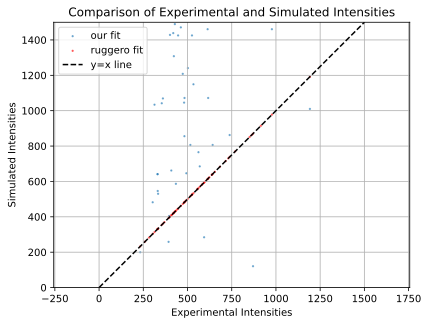

In [42]:

x = np.linspace(0 ,1500, 10000)
y = x
plt.scatter(best_data_plot['intensity_exp'], best_data_plot['intensity_sim'], s=2, alpha=0.5 , label='our fit')
plt.scatter(ruggero[:,3] , ruggero_scaled_sim, s=2, alpha=0.5, color='red', label='ruggero fit')
plt.plot(x , y, color='black', linestyle='--', label='y=x line')
plt.legend()
plt.grid(True)
plt.title('Comparison of Experimental and Simulated Intensities')
plt.xlabel('Experimental Intensities')
plt.ylabel('Simulated Intensities')
plt.axis('equal')
plt.xlim(0, 1500)
plt.ylim(0, 1500)
plt.show()